# Imports

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
from helper_metrics import count_missing_district, count_missing_district_total
import matplotlib.pyplot as plt
from helper_metrics import impute_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.metrics import mean_squared_error
import warnings
import altair as alt
warnings.filterwarnings("ignore")

# Load data

In [34]:
id_columns = ['Price of water', 'n_conflict_total', 'ndvi_score']
df = pd.read_csv("data/semiyearly_chosen_columns.csv").iloc[:,1:]
df = df[df.next_prevalence.isna()==False]


pow_index = df[df['Price of water'].isna()==True].index
conflict_index = df[df['n_conflict_total'].isna()==True].index
ndvi_index = df[df['ndvi_score'].isna()==True].index
ipc_index = df[df['phase3plus_perc_x'].isna()==True].index

In [3]:
df_imputed = pd.read_csv("data/imputed_data.csv").iloc[:,1:]
df_imputed = df_imputed[df_imputed.next_prevalence.isna()==False]
df_imputed

,date,district,total population,Under-Five Population,GAM,SAM,GAM Prevalence,SAM Prevalence,ipc,rainfall,ndvi,price_of_water,Total alarms,conflicts,prevalence_6lag,next_prevalence,month,increase,increase_numeric,district_encoded
0,2017-07-01,Adan Yabaal,65262.96000,13052.59200,4819.01697,1085.97565,0.36920,0.08320,0.18000,19.15667,0.21500,15.00000,2.16667,2.15000,NaN,0.35100,7,False,-0.01820,0
1,2017-07-01,Luuq,100476.76500,20095.35300,8673.15435,1306.19795,0.43160,0.06500,0.21000,24.24000,0.19333,15.00000,7.83333,1.50000,NaN,0.39260,7,False,-0.03900,59
2,2017-07-01,Buur Hakaba,165968.46000,33193.69200,11909.89669,3711.05477,0.35880,0.11180,0.35000,34.94500,0.34833,52.50000,6.16667,4.66667,NaN,0.28860,7,False,-0.07020,24
3,2017-07-01,Marka,282222.76500,56444.55300,20839.32897,4696.18681,0.36920,0.08320,0.17000,23.56500,0.29833,36.50000,11.83333,11.83333,NaN,0.35100,7,False,-0.01820,60
4,2017-07-01,Buuhoodle,71317.71000,14263.54200,4858.16241,1205.26930,0.34060,0.08450,0.37000,19.54000,0.21333,18.55116,2.33333,2.50000,NaN,0.20280,7,False,-0.13780,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,2021-01-01,Qardho,64346.00000,12870.00000,4555.00000,690.00000,0.35392,0.05361,0.23000,8.12000,0.14833,18.18449,0.16667,1.20000,0.39980,0.42264,1,True,0.06871,64
580,2021-01-01,Caluula,51766.00000,10355.00000,3720.00000,595.00000,0.35925,0.05746,0.16000,18.48000,0.23167,31.66667,3.66667,1.00000,0.47291,0.34388,1,False,-0.01537,28
581,2021-01-01,Cadale,61428.00000,12285.00000,3390.00000,435.00000,0.27595,0.03541,0.10000,19.06500,0.39667,18.03101,3.50000,2.75000,0.29052,0.28736,1,True,0.01141,27
582,2021-01-01,Afmadow,164086.00000,32815.00000,9905.00000,1660.00000,0.30184,0.05059,0.13000,23.69500,0.39500,18.16667,3.33333,8.66667,0.27809,0.39162,1,True,0.08977,2


In [4]:
def impute_dummy(df, feature, index):
    data = df[['date','district','next_prevalence',feature]]
    data['imputed'] = np.arange(0,len(data))
    for i in range(len(data)):
        if i in index:
            data.loc[i, 'imputed'] = 'imputed'
        else:
            data.loc[i, 'imputed'] = 'actual'
    return data

In [5]:
df_pow = impute_dummy(df_imputed, 'price_of_water', pow_index)
df_ndvi = impute_dummy(df_imputed, "ndvi", ndvi_index)
df_conlict = impute_dummy(df_imputed, "conflicts", conflict_index)
df_ipc = impute_dummy(df_imputed, "ipc", ipc_index)

In [6]:
def dot_range(result,lower_bound,upper_bound, save_value=False):
    metric = 'accuracy'
    result = result

    lower_bound = lower_bound
    upper_bound = upper_bound
    width = 200
    # construct a dataframe
    d = {
        'metric': [metric],
        'result': [result],
        'perfect accuracy': [upper_bound],
        'random guessing': [lower_bound]
    }
    validations = pd.DataFrame(data=d)

    # store a custom domain for the chart
    domain_ = (lower_bound-0.1, upper_bound + 0.1)

    # assign circles to 'metric' column
    circles = alt.Chart(
        validations, height=50, width=width).mark_circle(
            size=105, color='#FF7F50', opacity=1).encode(
                x='result:Q', y='metric:N')

    # then make the right tick for perfect
    ticks = alt.Chart(validations).mark_tick(
        size=30, color='#1070CA', thickness=3).encode(
            x=alt.X(
                'perfect accuracy:Q',
                scale=alt.Scale(domain=domain_),
                axis=alt.Axis(grid=False, title=None)),
            y='metric:N')

    # left band for random
    bands = alt.Chart(
        validations, height=50, width=width).mark_tick(
            size=30, color='gray', opacity=1, thickness=3).encode(
                x=alt.X(
                    'random guessing:Q',
                    scale=alt.Scale(),
                    axis=alt.Axis(grid=False, title=metric, titleAnchor='middle', titleAlign='center', titleFontSize=16, tickOpacity=0.7, labels=False)),
                y=alt.Y('metric:N', axis=alt.Axis(title=None, tickOpacity=0, labels=False))
    )

    # draw a line from x1 to x2, connecting the outer bounds
    lines = alt.Chart(validations).mark_rule(
        size=5, color='gray', opacity=0.2).encode(
            x='random guessing:Q', x2='perfect accuracy:Q', y='metric:N')

    text = bands.mark_text(
        align='center',
        baseline='middle',
        dy=-20,
        color="grey"# Nudges text to right so it doesn't appear on top of the bar
    ).encode(
        text='random guessing:Q'
    )

    text2 = bands.mark_text(
        align='center',
        baseline='middle',
        dy=-20,
        dx=135,
        color="blue"# Nudges text to right so it doesn't appear on top of the bar
    ).encode(
        text='perfect accuracy:Q'
    )




    chart = bands +text2+lines+ circles + ticks + text

    return chart



In [7]:
# RMSE for CONFLICTS KNN
dot_range(0.806,0,68)

alt.LayerChart(...)

In [8]:
# RMSE for CONFLICTS SPLINE
dot_range(2.3,0,68)

alt.LayerChart(...)

In [9]:
# RMSE for IPC KNN
dot_range(0.054,0,0.58)

alt.LayerChart(...)

In [10]:
# RMSE for NDVI KNN
dot_range(0.053,0,0.61)

alt.LayerChart(...)

In [11]:
# RMSE for PRICE OF WATER MICE
dot_range(11.296,0,100)

alt.LayerChart(...)

In [12]:
df.ndvi_score.max()

0.61

<AxesSubplot:xlabel='Features', ylabel='Missing Values'>

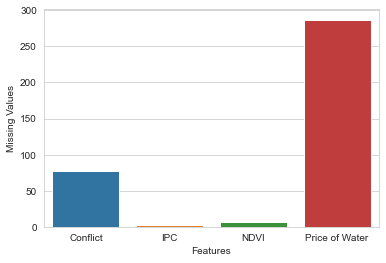

In [13]:
d = pd.DataFrame({"Features":["Conflict","IPC","NDVI","Price of Water"],"Missing Values":[77,2,7,287]})
sns.barplot(d,x="Features",y="Missing Values")

# Number of missing features

In [14]:
df = pd.read_csv("data/semiyearly_chosen_columns.csv").iloc[:,1:]

In [15]:
# total observations
len(df.columns)*len(df)

15088

In [16]:
predictors = df.select_dtypes(exclude=["object", "category"]).drop(['next_prevalence', 'increase_numeric','GAM','SAM','MAM','Under-Five Population'],axis=1)
len(predictors.columns)*len(predictors)

9184

In [17]:
predictors.isna().sum().sum()/9184*100

5.651132404181185

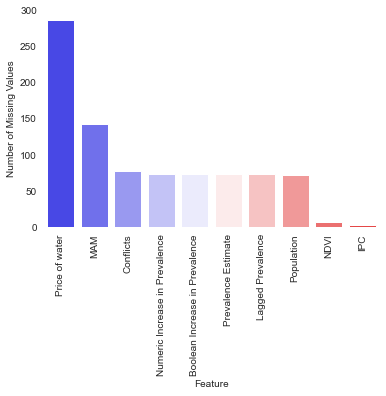

In [18]:
missing = df.isna().sum().reset_index().rename(columns={"index":"Feature", 0:"Number of Missing Values"}).sort_values("Number of Missing Values",ascending=False)
missing = missing[missing['Number of Missing Values']>0].reset_index().iloc[:,1:]
missing.loc[2,'Feature'] = 'Conflicts'
missing.loc[3,'Feature'] = 'Numeric Increase in Prevalence'
missing.loc[4,'Feature'] = 'Boolean Increase in Prevalence'
missing.loc[5,'Feature'] = 'Prevalence Estimate'
missing.loc[6,'Feature'] = 'Lagged Prevalence'
missing.loc[7,'Feature'] = 'Population'
missing.loc[8,'Feature'] = 'NDVI'
missing.loc[9,'Feature'] = 'IPC'


# Turns off grid on the left Axis.
my_dpi=96
#plt.figure(figsize=(16,10))
ax = sns.barplot(missing, x="Feature", y="Number of Missing Values",palette="bwr");
ax.grid(False)
ax.spines['left'].set_visible(True)
plt.box(False)
plt.xticks(rotation=90);



plt.savefig('Images/missing.png',dpi=300, bbox_inches='tight')

# Somehow show imputed values against original values

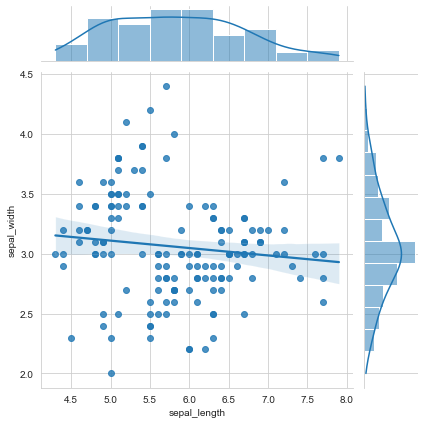

In [19]:
# library & dataset
import seaborn as sns
import matplotlib.pyplot as plt
df = sns.load_dataset('iris')

# Custom the inside plot: options are: “scatter” | “reg” | “resid” | “kde” | “hex”
sns.jointplot(x=df["sepal_length"], y=df["sepal_width"], kind='reg');

In [20]:
df_ndvi.loc[582,'imputed'] = 'actual'
df_ndvi.loc[583,'imputed'] = 'actual'

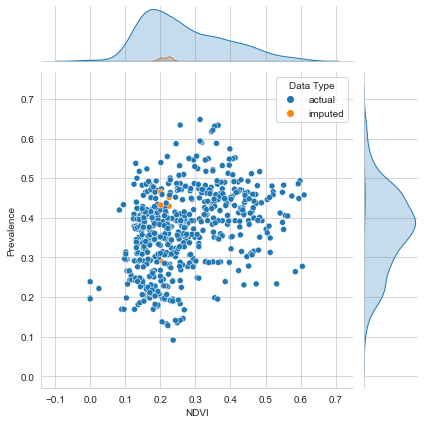

In [21]:
ax = sns.jointplot(x=df_ndvi["ndvi"], y=df_ndvi["next_prevalence"], kind='scatter',hue=df_ndvi.imputed);
plt.ylabel("Prevalence")
plt.xlabel("NDVI");
plt.legend(title="Data Type");

In [22]:
df_pow.loc[582,'imputed'] = 'actual'
df_pow.loc[583,'imputed'] = 'actual'

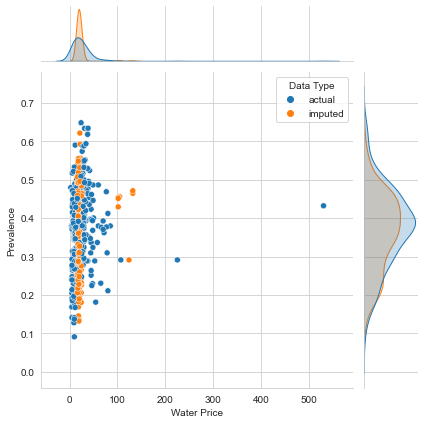

In [23]:
ax = sns.jointplot(x=df_pow["price_of_water"], y=df_pow["next_prevalence"], kind='scatter',hue=df_pow.imputed);
plt.ylabel("Prevalence")
plt.xlabel("Water Price")
plt.legend(title="Data Type");

In [24]:
df_conlict.loc[582,'imputed'] = 'actual'
df_conlict.loc[583,'imputed'] = 'actual'

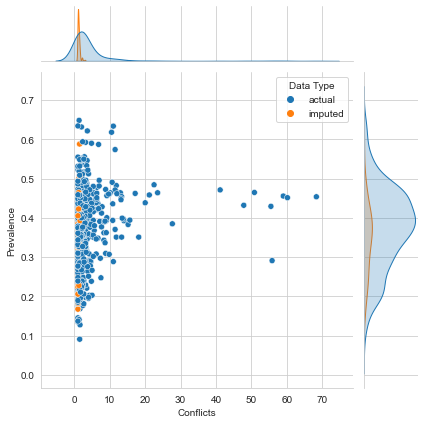

In [25]:
ax = sns.jointplot(x=df_conlict["conflicts"], y=df_conlict["next_prevalence"], kind='scatter',hue=df_conlict.imputed, hue_order=["actual","imputed"]);
plt.ylabel("Prevalence")
plt.xlabel("Conflicts")
plt.legend(title="Data Type");

In [26]:
df_ipc.loc[582,'imputed'] = 'actual'
df_ipc.loc[583,'imputed'] = 'actual'

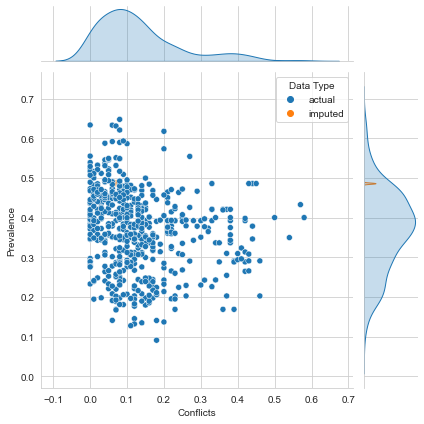

In [27]:
ax = sns.jointplot(x=df_ipc["ipc"], y=df_ipc["next_prevalence"], kind='scatter',hue=df_ipc.imputed, hue_order=["actual","imputed"]);
plt.ylabel("Prevalence")
plt.xlabel("Conflicts")
plt.legend(title="Data Type");

# Comparison Plots

In [32]:
d = df_pow.dropna()
d

,date,district,next_prevalence,price_of_water,imputed
0,2017-07-01,Adan Yabaal,0.35100,15.00000,actual
1,2017-07-01,Luuq,0.39260,15.00000,actual
2,2017-07-01,Buur Hakaba,0.28860,52.50000,actual
3,2017-07-01,Marka,0.35100,36.50000,actual
4,2017-07-01,Buuhoodle,0.20280,18.55116,imputed
...,...,...,...,...,...
579,2021-01-01,Qardho,0.42264,18.18449,imputed
580,2021-01-01,Caluula,0.34388,31.66667,actual
581,2021-01-01,Cadale,0.28736,18.03101,imputed
582,2021-01-01,Afmadow,0.39162,18.16667,actual


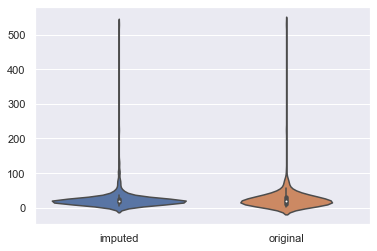

In [45]:
p = pd.DataFrame({"imputed":d.price_of_water,"original":df['Price of water']})
sns.violinplot(p);

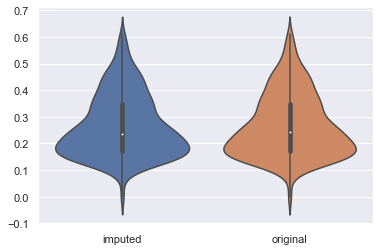

In [51]:
p = pd.DataFrame({"imputed":df_ndvi.ndvi,"original":df.ndvi_score})
sns.violinplot(p);

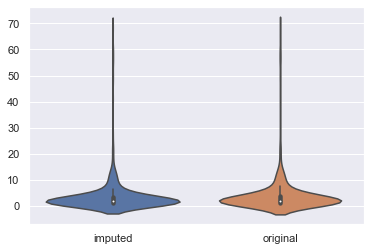

In [50]:
p = pd.DataFrame({"imputed":df_conlict.conflicts,"original":df.n_conflict_total})
sns.violinplot(p);

<AxesSubplot:>

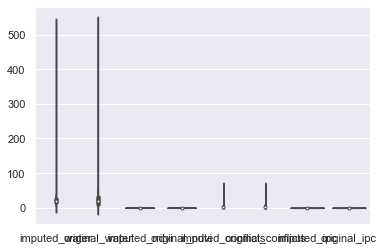

In [54]:
p = pd.DataFrame({"imputed_water":d.price_of_water,"original_water":df['Price of water'],
              "imputed_ndvi":df_ndvi.ndvi,"original_ndvi":df.ndvi_score,
              "imputed_conflicts":df_conlict.conflicts,"original_conflicts":df.n_conflict_total,
              "imputed_ipc":df_ipc.ipc, "original_ipc":df.phase3plus_perc_x,
              })

sns.violinplot(p)